# COGS 108 - Final Project (change this to your project's title)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X] YES - make available
* [  ] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Jonathan Cheung
- Joshua Chuang
- Joyce Hu
- Ester Tsai
- Sam Wong

<a id='research_question'></a>
# Research Question

Which factor, among factors such as director, genre, and sentiment analysis of the plot, has the highest correlation with American film's box office sale?

<a id='background'></a>

## Background & Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

-----------------------


- Dataset Name: "American Films.csv"
- Link to the dataset: Web scraped from Wikipedia, so there is no link
- Number of observations: 2521

This dataset was scraped from the Wikipeida page "American Films by Genre" (https://en.wikipedia.org/wiki/Category:American_films_by_genre). It contains the variables 'Film name', 'Genre', 'Plot', 'Directed by', 'Written by', 'Story by', 'Produced by', 'Starring', 'Cinematography', 'Edited by', 'Music by', 'Production company', 'Distributed by', 'Duration (min)', 'Release year', 'Budget (mil dollar)', 'Box office (mil dollar)', 'VADER Sentiment', 'TextBlob Subjectivity', and 'TextBlob Polarity'. It has been filtered to include only the films that have vaild box office values.

# Setup

In [2]:
# Basic libraries
import numpy as np

# Pandas
import pandas as pd
pd.set_option('display.max_columns', None)

# Data visualization
import seaborn as sns
sns.set(font_scale=2, style="white")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

from scipy.stats import zscore

# set plotting size parameter
plt.rcParams['figure.figsize'] = (12, 5)

# Webscraping
import requests
from bs4 import BeautifulSoup

# Textual and sentiment analysis
import re

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from textblob import TextBlob

import nltk
nltk.download('punkt')
from LeXmo import LeXmo


# Improve resolution
%config InlineBackend.figure_format ='retina'

# Ignore wanrnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from dateutil import parser

import string
from collections import defaultdict

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tsaie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tsaie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Cleaning

Describe your data cleaning steps here.

## 1) Import Scraped Dataset

In [2]:
df_unfiltered = pd.read_csv('American Films (before cleaning).csv')

# Filter the dataset to include only the rows with a non-null 'Box office'
df = df_unfiltered[df_unfiltered['Box office'].notnull()]

df.head()

,Film name,Genre,Plot,Directed by,Written by,Story by,Produced by,Starring,Cinematography,Edited by,Music by,Production company,Distributed by,Release date,Running time,Budget,Box office
0,The 2nd (film),Action,"While picking up his son at his college dorm, ...",Brian Skiba,Eric Bromberg/ Paul Taegel,NaN,Geoffrey James Clark/ Ryan Phillippe/ Kirk Sha...,Ryan Phillippe/ Casper Van Dien/ Jack Griffo/ ...,Adam Biddle,Scott Conrad,Richard Patrick,NaN,Momentum Pictures/ Voltage Pictures,"September 1, 2020",93 minutes,NaN,"$12,604"
3,12 Rounds (film),Action,A sting operation to capture arms dealer Miles...,Renny Harlin,Daniel Kunka,NaN,Becki Cross Trujillo/ Mark Gordon/ Renny Harli...,John Cena/ Aidan Gillen/ Ashley Scott/ Steve H...,David Boyd,Brian Berdan,Trevor Rabin,NaN,20th Century Fox,NaN,109 minutes,$6.7 million,$17.3 million
6,13 Minutes (2021 film),Action,Four families in the fictional Oklahoma town o...,Lindsay Gossling,Lindsay Gossling,Travis Farncombe,Lindsay Gossling/ Travis Farncombe/ Karen Harn...,Trace Adkins/ Thora Birch/ Peter Facinelli/ An...,Steve Mason,Lisa Grootenboer,Ariel Marx,NaN,Quiver Distribution,"October 29, 2021",108 minutes,NaN,"$67,413"
11,Aces: Iron Eagle III,Action,U.S. Air Force Brigadier General Charles 'Chap...,John Glen,Kevin Alyn Elders,NaN,Ron Samuels,Louis Gossett Jr./ Rachel McLish/ Paul Freeman...,Alec Mills,Bernard Gribble,Harry Manfredini,NaN,Seven Arts (through New Line Cinema)/ New Line...,NaN,98 minutes,$13.5 million,$2.5 million
15,Air Collision,Action,After a major electromagnetic storm cripples c...,Liz Adams,Liz Adams,NaN,David Michael Latt,Reginald VelJohnson/ Jordan Ladd/ Gerald Webb,Stuart Brereton,Rob Pallatina,Chris Ridenhour,NaN,The Asylum,"March 27, 2012",92 minutes,£4 million,£2.56


## 2) Data Collection

This section contains the code we used to scrape the data from Wikipedia.
### Specify the URLs to scrape

In [3]:
genre_link = {
    'Action': [
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pageuntil=Driving+Force+%281989+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Driving+Force+%281989+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Marksman%2C+The%0AThe+Marksman+%282005+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_action_films&pagefrom=Spider-Man+3#mw-pages'
    ],
    'Crime': [
        'https://en.wikipedia.org/wiki/Category:American_crime_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Dial+Red+O#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Ivy+%28Film%29%0AIvy+%281947+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=One+Stolen+Night+%281929+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_crime_films&pagefrom=Tenderloin+%28film%29#mw-pages'
    ],
    'War': [
        'https://en.wikipedia.org/wiki/Category:American_war_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_war_films&pagefrom=Retreat%2C+Hell%21#mw-pages'
    ],
    'Romance': [
        'https://en.wikipedia.org/wiki/Category:American_romance_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_romance_films&pagefrom=Sporting+Venus%2C+The%0AThe+Sporting+Venus#mw-pages'
    ],
    'Thriller': [
        'https://en.wikipedia.org/wiki/Category:American_thriller_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_thriller_films&pagefrom=Godsend+%282004+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_thriller_films&pagefrom=Poltergeist+%28film%29%0APoltergeist+%281982+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_thriller_films&pagefrom=Winchester+%28film%29#mw-pages'
    ],
    'Horror': [
        'https://en.wikipedia.org/wiki/Category:American_horror_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_horror_films&pagefrom=Isle+of+the+Dead+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_horror_films&pagefrom=West+of+Hell#mw-pages'
    ],
    'Biographical': [
        'https://en.wikipedia.org/wiki/Category:American_biographical_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_biographical_films&pagefrom=I+Wanna+Dance+with+Somebody+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_biographical_films&pagefrom=Story+of+Alexander+Graham+Bell%0AThe+Story+of+Alexander+Graham+Bell#mw-pages'
    ],
    'Satirical': [
        'https://en.wikipedia.org/wiki/Category:American_satirical_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_satirical_films&pagefrom=Hospital%2C+The%0AThe+Hospital#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_satirical_films&pagefrom=Taintlight%0ATaintlight#mw-pages'
    ],
    'Science Fiction': [
        'https://en.wikipedia.org/wiki/Category:American_science_fiction_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_Western_(genre)_films&pagefrom=Big+Sombrero%2C+The%0AThe+Big+Sombrero+%28film%29#mw-pages'
    ],
    'Monster': [
        'https://en.wikipedia.org/wiki/Category:American_monster_movies',
        'https://en.wikipedia.org/w/index.php?title=Category:American_monster_movies&pagefrom=Fly%2C+The%0AThe+Fly+%281986+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_monster_movies&pagefrom=Nailbiter#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_monster_movies&pagefrom=World+Without+End+%28film%29#mw-pages'
    ],
    'Mystery': [
        'https://en.wikipedia.org/wiki/Category:American_mystery_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=Deceiver+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=House+of+Fear%2C+The%0AThe+House+of+Fear+%281915+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=Murder+She+Baked%0AMurder%2C+She+Baked#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=Seven+Footprints+To+Satan+%28Film%29%0ASeven+Footprints+to+Satan#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_mystery_films&pagefrom=X+Marks+The+Spot%0AX+Marks+the+Spot+%281942+film%29#mw-pages'
    ],
    'Drama': [
        'https://en.wikipedia.org/wiki/Category:American_drama_films',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Are+These+Our+Children#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Black+Circle+Boys#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Chad+Hanna#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Dancer%27s+Peril%0AThe+Dancer%27s+Peril#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Drunktown%27s+Finest%0ADrunktown%27s+Finest#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Flag+Day+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=God%27s+Little+Acre%0AGod%27s+Little+Acre+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Highway+13+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Invitation+to+Happiness#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Last+Voyage%2C+The%0AThe+Last+Voyage#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Lure+of+the+Swamp#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Million+Dollar+Ransom#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Nomads%0ANomads+%282010+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Pearl+%282020+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Reflections+in+a+Golden+Eye+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Seven+Pounds#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Sporting+Blood+%281940+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Tarantella+%281995+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Treading+Water+%28Film%29%0ATreading+Water+%282001+film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=Water+Man%2C+The+%28film%29%0AThe+Water+Man+%28film%29#mw-pages',
        'https://en.wikipedia.org/w/index.php?title=Category:American_drama_films&pagefrom=World+For+Ransom%0AWorld+for+Ransom#mw-pages'
    ]
}

### Specify the information to include in our dataset

In [4]:
info_list = [
    'Film name', 
    'Genre', 
    'Plot',
    'Directed by',
    'Written by',
    'Story by',
    'Produced by',
    'Starring',
    'Cinematography',
    'Edited by',
    'Music by',
    'Production company',
    'Distributed by',
    'Release date',
    'Running time',
    'Budget',
    'Box office'
]

### Web scrape Wikipedia and construct dataset

In [5]:
def web_scrape_film_wiki_pages(genre_link):

    # Create a blank dataframe and assign column names
    df = pd.DataFrame(columns=info_list)

    # Loop through the genres
    # category_links is a list of URLs for the same genre, but each URL contains around 200 individual films
    for genre, category_links in genre_link.items():

        # Each movie genre has several URLs since not everything can fit on the same page
        # Loop through the URLs in category_links to access all the URLs for each movie genre
        for category_link in category_links:
            req = requests.get(category_link, timeout=50)
            soup = BeautifulSoup(req.content, 'html') # get contents of web page    

            soup.find('div', {'class': 'mw-content-ltr'}).find_all('a', href=True)

            # Each category_link has around 200 individual films' URLs
            # This for loop populates name_links dictionary with the film name as key and Wikipedia page URL as value
            name_links = {}
            for a in soup.find('div', {'class': 'mw-content-ltr'}).find_all('a', href=True):
                film_name = a.text
                link_end = a['href']
                link = 'https://en.wikipedia.org' + link_end
                if 'Categor' not in link: # skip if 'Category' or 'Categorization' is in the link
                    name_links[film_name] = link

            # Loop through the individual films' URLs to extract wanted info
            for film_name, link in name_links.items():
                req = requests.get(link, timeout=50)
                soup = BeautifulSoup(req.content, 'html') # get contents of web page
                tag_contents = soup.select('p, span.mw-headline')

                # Extract the plot (can also be named "Premise" or "Synopsis") if it exists
                start_index_of_plot = -1
                end_index_of_plot = -1
                plot_exists = False

                for i, tag_content in enumerate(tag_contents):
                    tag = tag_content.name
                    content = tag_content.text

                    if (plot_exists) & (tag == 'span'):
                        end_index_of_plot = i
                        break

                    if (content == 'Plot') | (content == 'Premise') | (content == 'Synopsis'):
                        start_index_of_plot = i + 1
                        plot_exists = True

                plot = []
                for content in tag_contents[start_index_of_plot: end_index_of_plot]:
                    par = content.text
                    plot += [par]

                plot = "".join(plot).strip()

                # If plot exists, extract other info as well
                if len(plot) >= 1:

                    film_dict = {'Film name': film_name, 'Genre': genre, 'Plot': plot}

                    # Get other info on the film, if the info table eixsts 
                    try:
                        req = requests.get(link, timeout=50)
                        soup = BeautifulSoup(req.content, 'html')
                        wiki_tables = soup.select('table', {'class': 'infobox vevent'})
                        wiki_table = wiki_tables[0] # get info table

                        # Loop through the tables until we have the info table we want
                        i = 0
                        while 'Directed by' not in wiki_table.text:
                            i += 1
                            wiki_table = wiki_tables[i]

                        # Some minor data cleaning
                        table_html = str(wiki_table).replace('<br/>', '/ ').replace('</li>', '/ ') # replace new line characters with a slash to separate the list of names
                        table_html = re.sub(r"\[\d+\]", "", table_html) # remove brackets (which provide link to references, but are not needed for our project)

                        # Use pd.read_html to create pandas dataframe of the info table
                        df = pd.read_html(table_html) 
                        df = pd.DataFrame(df[0]) # convert list to dataframe
                        df.columns = ['col_name', 'info']
                        df['col_name'] = df['col_name'].replace('/', ' ').replace('companies', 'company').replace('dates', 'date') # fix minor style error
                        df['info'] = df['info'].apply(lambda x: x[:-1] if str(x)[-1] == "/" else x) # fix minor style error

                        info_dict = {k: v for (k, v) in zip(list(df['col_name']), list(df['info'])) if k in info_list}
                        dict_to_append = {**film_dict, **info_dict}

                    # If the info table does not exist, then only append the film name, genre, and plot
                    except:
                        dict_to_append = film_dict

                    # Update the dataframe
                    df = df.append(dict_to_append, ignore_index=True)    
                    
    return df

## 3) Clean and Prepare the Dataset for Analysis
How 'clean' is the data?
- The dataset does require some cleaning. Some current issues with the dataset include:
    - Many string variables contain extra symbols such as reference brackets.
    - 'Running time' is not in a standardized format and is not quantitative. Ideally, it should be an integer representing the number of minutes.
    - 'Budget' is not in a standardized format and is not quantitative. Ideally, it should be a float representing the dollar amount in millions.
    - 'Box office' is not in a standardized format and is not quantitative. Ideally, it should be a float representing the dollar amount in millions.
    - Many columns contain a list of names, which is not ideal for aggregation analysis. We will perform one-hot encoding after choosing which variables to use in our future analysis.

### Clean up text columns

In [6]:
# Remove references from 'Plot' column   
def remove_references(df, col_name):
    return df[col_name].replace(r'\[\d+\]','', regex=True).replace(r'\[\w\]','', regex=True) 
    
df['Plot'] = remove_references(df, 'Plot')
df['Budget'] = remove_references(df, 'Budget')
df['Box office'] = remove_references(df, 'Box office')

### Extract numerical and datetime info from text variables
- 'Running time' &rarr; 'Duration (min)'
- 'Release date' &rarr; 'Release year'
- 'Budget' &rarr; 'Budget (mil dollar)'
- 'Box office' &rarr; 'Box office (mil dollar)'

In [7]:
# 'Duration (min)' extracts the number of minutes from 'Running time'
df['Duration (min)'] = df['Running time'].str.lower().str.extract(r'(?P<duration>[\d]+) min')
# df.drop(columns=['Running time'])


# 'Release year' extracts the year from 'Release date'
df['Release year'] = df['Release date'].str.extract(r'(\d{4})')
# df.drop(columns=['Release date'])


# Function to extract the dollar value in millions from messy string variables
# Averages the values if given a range
def extract_million_dollar(string):
    if (type(string) != str) or ('$' not in string):
        return np.nan
    
    string = string.replace(',', '')
    result = np.nan
    
    if 'equivalent' in string:
        start_idx = string.find('equivalent')+len('equivalent')
        result = float(re.findall(r'(\d+\.?\d*)', string[start_idx:])[0])
        if 'mil' not in string[start_idx:]:
            result = result / 1_000_000
        return result
    
    # Remove all content inside parentheses and brackets
    string = re.sub(r'\([^)]*\)', '', string)
    string = re.sub(r'\[[^]]*\]', '', string)
    nums = re.findall(r'(\d+\.?\d*)', string)
    
    if len(nums) >= 2:
        if ('mil' in string) & ('–' in string):
            nums[0] = float(nums[0])
        else:    
            start_idx = string.find(nums[0])+len(nums[0])
            end_idx = string.find(nums[1])
            if 'mil' in string[start_idx: end_idx]:
                nums[0] = float(nums[0])
            else:
                nums[0] = float(nums[0]) / 1_000_000

        final_num_start_idx = string.find(nums[1])           
        if 'mil' in string[final_num_start_idx:]:
            nums[1] = float(nums[1])
        else:
            nums[1] = float(nums[1]) / 1_000_000

        if ('/' in string) & ('or' not in string):
            result = np.sum(nums[:2])
        else:
            result = np.mean(nums[:2])

    else:
        if 'mil' in string:
            result = float(nums[0])
        else:
            result = float(nums[0]) / 1_000_000
            
    return result


# 'Budget (mil)' extracts the dollar value in millions from 'Budget'
df['Budget (mil dollar)'] = df['Budget'].apply(extract_million_dollar)
# df.drop(columns=['Budget'])

# 'Box office (mil)' extracts the dollar value in millions from 'Box office'
df['Box office (mil dollar)'] = df['Box office'].apply(extract_million_dollar)
# df.drop(columns=['Box office'])

Sanity check the values and assign anything unreasonable to np.nan:

In [8]:
df.describe()

,Budget (mil dollar),Box office (mil dollar)
count,1703.000000,2494.000000
mean,165.489668,31.186075
std,6057.690205,86.331881
min,0.000040,0.000000
25%,1.500000,0.821029
50%,6.500000,2.800000
75%,20.000000,16.800000
max,250000.150000,894.900000


In [9]:
# Check which budget is unreasonably high
df[df['Budget (mil dollar)'] > 500]

,Film name,Genre,Plot,Directed by,Written by,Story by,Produced by,Starring,Cinematography,Edited by,Music by,Production company,Distributed by,Release date,Running time,Budget,Box office,Duration (min),Release year,Budget (mil dollar),Box office (mil dollar)
4307,November (2004 film),Mystery,"On the evening of November 7, photographer Sop...",Greg Harrison,Benjamin Brand/ Greg Harrison,NaN,Jake Abraham/ Danielle Renfrew/ Gary Winick,Courteney Cox,Nancy Schreiber,Greg Harrison,Lew Baldwin,NaN,Sony Pictures Classics,NaN,73 minutes,"$150,000/ $250,000/ $1.5 million","$192,186",73,NaN,250000.15,0.192186


In [10]:
# Manually fix the budget value
idx = df[df['Budget (mil dollar)'] > 500].index
df.at[idx, 'Budget (mil dollar)'] = 1.5

### Extract the first person from the list of people in some columns
All of these list-like values contain objects (typically names) that are separated by a slash ("/"). Use `.split('/')` to transform the string into a list.

Working with the assumption that the values are listed in order of importance, we want to simplify a list-like value by extracting the first value in the list. For example, `Starring` for "The 2nd (film)" originally contained "Ryan Phillippe/ Casper Van Dien/ Jack Griffo/ Lexi Simonsen/ William Katt/ Richard Burgi/ William McNamara/ Samaire Armstrong/ Jacob Grodnik/ Randy Charach", but we will extract only the first person in the list, "Ryan Phillippe".

In [11]:
def extract_first(string):
    if type(string) == str:
        lst = string.split('/')
        return lst[0].strip()
    else:
        return np.nan

cols = ['Directed by', 'Written by', 'Story by',
        'Produced by', 'Starring', 'Cinematography', 'Edited by', 'Music by',
        'Production company', 'Distributed by']

for col in cols:
    df[col] = df[col].apply(extract_first)

### Sentiment Analysis
VADER
- VADER Sentiment lies between [-1,1]
    - -1 defines a negative sentiment and 1 defines a positive sentiment.
    - VADER performs better than TextBlob on identifying negative sentiment.

In [12]:
VADER_SentimentIntensityAnalyzer = SentimentIntensityAnalyzer()

def get_VADER_sentiment(text):
    return VADER_SentimentIntensityAnalyzer.polarity_scores(text)

df['VADER Sentiment'] = df['Plot'].apply(get_VADER_sentiment)

df['VADER negative'] = df['VADER Sentiment'].apply(lambda x: x['neg'])
df['VADER neutral'] = df['VADER Sentiment'].apply(lambda x: x['neu'])
df['VADER positive'] = df['VADER Sentiment'].apply(lambda x: x['pos'])
df['VADER compound'] = df['VADER Sentiment'].apply(lambda x: x['compound'])
df['VADER compound (absolute value)'] = df['VADER Sentiment'].apply(lambda x: abs(x['compound']))

TextBlob
- TextBlob Polarity lies between [-1,1]
    - -1 defines a negative sentiment and 1 defines a positive sentiment. 
    - Negation words reverse the polarity. When any negation is added with any sentence it simply multiplies -0.5 to the polarity score of the word. 
- TextBlob Subjectivity lies between [0,1]. 
    - Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.

In [13]:
def get_TextBlob_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_TextBlob_polarity(text):
    return TextBlob(text).sentiment.polarity

df['TextBlob subjectivity'] = df['Plot'].apply(get_TextBlob_subjectivity)
df['TextBlob polarity'] = df['Plot'].apply(get_TextBlob_polarity)

## 4) Resulting Dataset

In [14]:
# Filter out the rows without a valid value for 'Box office (mil dollar)'
df = df[df['Box office (mil dollar)'].notnull()]

df.to_csv('American Films.csv', index=False)

In [3]:
df = pd.read_csv('American Films.csv')

df

,Film name,Genre,Plot,Directed by,Written by,Story by,Produced by,Starring,Cinematography,Edited by,Music by,Production company,Distributed by,Release date,Running time,Budget,Box office,Duration (min),Release year,Budget (mil dollar),Box office (mil dollar),VADER Sentiment,VADER negative,VADER neutral,VADER positive,VADER compound,VADER compound (absolute value),TextBlob subjectivity,TextBlob polarity
0,The 2nd (film),Action,"While picking up his son at his college dorm, ...",Brian Skiba,Eric Bromberg,NaN,Geoffrey James Clark,Ryan Phillippe,Adam Biddle,Scott Conrad,Richard Patrick,NaN,Momentum Pictures,"September 1, 2020",93 minutes,NaN,"$12,604",93.0,2020.0,NaN,0.012604,"{'neg': 0.056, 'neu': 0.804, 'pos': 0.139, 'co...",0.056,0.804,0.139,0.7845,0.7845,0.450000,0.016667
1,12 Rounds (film),Action,A sting operation to capture arms dealer Miles...,Renny Harlin,Daniel Kunka,NaN,Becki Cross Trujillo,John Cena,David Boyd,Brian Berdan,Trevor Rabin,NaN,20th Century Fox,NaN,109 minutes,$6.7 million,$17.3 million,109.0,NaN,6.70,17.300000,"{'neg': 0.071, 'neu': 0.873, 'pos': 0.056, 'co...",0.071,0.873,0.056,-0.9610,0.9610,0.385748,-0.084798
2,13 Minutes (2021 film),Action,Four families in the fictional Oklahoma town o...,Lindsay Gossling,Lindsay Gossling,Travis Farncombe,Lindsay Gossling,Trace Adkins,Steve Mason,Lisa Grootenboer,Ariel Marx,NaN,Quiver Distribution,"October 29, 2021",108 minutes,NaN,"$67,413",108.0,2021.0,NaN,0.067413,"{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'comp...",0.263,0.737,0.000,-0.9524,0.9524,0.431250,-0.031250
3,Aces: Iron Eagle III,Action,U.S. Air Force Brigadier General Charles 'Chap...,John Glen,Kevin Alyn Elders,NaN,Ron Samuels,Louis Gossett Jr.,Alec Mills,Bernard Gribble,Harry Manfredini,NaN,Seven Arts (through New Line Cinema),NaN,98 minutes,$13.5 million,$2.5 million,98.0,NaN,13.50,2.500000,"{'neg': 0.088, 'neu': 0.861, 'pos': 0.051, 'co...",0.088,0.861,0.051,-0.9872,0.9872,0.338125,-0.053258
4,American Ninja,Action,"As an alternative to prison, young American Jo...",Sam Firstenberg,Paul De Mielche (screenplay),NaN,Yoram Globus,Michael Dudikoff,Hanania Baer,Andy Horvitch,Michael Linn,NaN,Cannon Film Distributors,"August 30, 1985",95 minutes,"$1,000,000 (est.)","$10,499,694 (domestic)",95.0,1985.0,1.00,10.499694,"{'neg': 0.161, 'neu': 0.789, 'pos': 0.05, 'com...",0.161,0.789,0.050,-0.9981,0.9981,0.429046,-0.088511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,The Young Messiah,Drama,Seven-year-old Jesus is playing in Alexandria ...,Cyrus Nowrasteh,Cyrus Nowrasteh,NaN,Michael Barnathan,Adam Greaves-Neal,Joel Ransom,Geoffrey Rowland,John Debney,NaN,Focus Features,"March 11, 2016",111 minutes,$18.5 million,$7.3 million,111.0,2016.0,18.50,7.300000,"{'neg': 0.131, 'neu': 0.807, 'pos': 0.062, 'co...",0.131,0.807,0.062,-0.9946,0.9946,0.377682,0.033788
2490,The Young Philadelphians,Drama,Newlywed Kate Judson Lawrence (Diane Brewster)...,Vincent Sherman,NaN,NaN,James Gunn,Paul Newman,Harry Stradling,William H. Ziegler,Ernest Gold,NaN,Warner Bros. Pictures,"May 19, 1959",136 minutes,NaN,$2.8 million (est. US/ Canada rentals),136.0,1959.0,NaN,2.800000,"{'neg': 0.149, 'neu': 0.704, 'pos': 0.147, 'co...",0.149,0.704,0.147,-0.5300,0.5300,0.472809,0.126522
2491,Zabriskie Point (film),Drama,"In a room at a university campus in 1970, whit...",Michelangelo Antonioni,NaN,Michelangelo Antonioni,Carlo Ponti,Mark Frechette,Alfio Contini,Franco Arcalli,John Fahey,NaN,Metro-Goldwyn-Mayer,NaN,112 minutes,$7 million,$1 million[Note 1],112.0,NaN,7.00,1.000000,"{'neg': 0.117, 'neu': 0.801, 'pos': 0.082, 'co...",0.117,0.801,0.082,-0.9864,0.9864,0.375393,0.044276
2492,Zero Day (2003 film),Drama,"Andre Kriegman (Born July 17, 1982) and Calvin...",Ben Coccio,Ben Coccio,NaN,Ben Coccio,Andre Keuck,NaN,NaN,NaN,NaN,Avatar Films,"September 3, 2003",92 minutes,"$20,000","$8,466",92.0,2003.0,0.02,0.008466,"{'neg': 0.112, 'neu': 0.849, 'pos': 0.039, 'co...",0.112,0.8

Note: For all the categorical values we plan to analyze, perform statistical tests on, or create machine learning models with, we may need to perform one-hot encoding to create quantitative values. But we will perform that step after EDA as needed.

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

### Is there a relation between budget and box office?

Import American Films dataset into "df."

In [16]:
df = pd.read_csv('American Films.csv')
df.head()

,Film name,Genre,Plot,Directed by,Written by,Story by,Produced by,Starring,Cinematography,Edited by,Music by,Production company,Distributed by,Release date,Running time,Budget,Box office,Duration (min),Release year,Budget (mil dollar),Box office (mil dollar),VADER Sentiment,VADER negative,VADER neutral,VADER positive,VADER compound,VADER compound (absolute value),TextBlob subjectivity,TextBlob polarity
0,The 2nd (film),Action,"While picking up his son at his college dorm, ...",Brian Skiba,Eric Bromberg,NaN,Geoffrey James Clark,Ryan Phillippe,Adam Biddle,Scott Conrad,Richard Patrick,NaN,Momentum Pictures,"September 1, 2020",93 minutes,NaN,"$12,604",93.0,2020.0,NaN,0.012604,"{'neg': 0.056, 'neu': 0.804, 'pos': 0.139, 'co...",0.056,0.804,0.139,0.7845,0.7845,0.450000,0.016667
1,12 Rounds (film),Action,A sting operation to capture arms dealer Miles...,Renny Harlin,Daniel Kunka,NaN,Becki Cross Trujillo,John Cena,David Boyd,Brian Berdan,Trevor Rabin,NaN,20th Century Fox,NaN,109 minutes,$6.7 million,$17.3 million,109.0,NaN,6.7,17.300000,"{'neg': 0.071, 'neu': 0.873, 'pos': 0.056, 'co...",0.071,0.873,0.056,-0.9610,0.9610,0.385748,-0.084798
2,13 Minutes (2021 film),Action,Four families in the fictional Oklahoma town o...,Lindsay Gossling,Lindsay Gossling,Travis Farncombe,Lindsay Gossling,Trace Adkins,Steve Mason,Lisa Grootenboer,Ariel Marx,NaN,Quiver Distribution,"October 29, 2021",108 minutes,NaN,"$67,413",108.0,2021.0,NaN,0.067413,"{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'comp...",0.263,0.737,0.000,-0.9524,0.9524,0.431250,-0.031250
3,Aces: Iron Eagle III,Action,U.S. Air Force Brigadier General Charles 'Chap...,John Glen,Kevin Alyn Elders,NaN,Ron Samuels,Louis Gossett Jr.,Alec Mills,Bernard Gribble,Harry Manfredini,NaN,Seven Arts (through New Line Cinema),NaN,98 minutes,$13.5 million,$2.5 million,98.0,NaN,13.5,2.500000,"{'neg': 0.088, 'neu': 0.861, 'pos': 0.051, 'co...",0.088,0.861,0.051,-0.9872,0.9872,0.338125,-0.053258
4,American Ninja,Action,"As an alternative to prison, young American Jo...",Sam Firstenberg,Paul De Mielche (screenplay),NaN,Yoram Globus,Michael Dudikoff,Hanania Baer,Andy Horvitch,Michael Linn,NaN,Cannon Film Distributors,"August 30, 1985",95 minutes,"$1,000,000 (est.)","$10,499,694 (domestic)",95.0,1985.0,1.0,10.499694,"{'neg': 0.161, 'neu': 0.789, 'pos': 0.05, 'com...",0.161,0.789,0.050,-0.9981,0.9981,0.429046,-0.088511


Assign "quant" to be the columns that Quantitative EDA will be performed on. This includes the duration, budget, release year, and box office columns.

In [17]:
quant = df[['Duration (min)', 'Release year', 'Budget (mil dollar)', 'Box office (mil dollar)']]

Displaying descriptive statistics on the dataset.

In [18]:
quant.describe()

,Duration (min),Release year,Budget (mil dollar),Box office (mil dollar)
count,2461.000000,1593.000000,1696.000000,2494.000000
mean,103.955709,1978.590709,18.764658,31.186075
std,22.544411,25.992644,33.452791,86.331881
min,19.000000,1914.000000,0.000040,0.000000
25%,92.000000,1955.000000,1.500000,0.821029
50%,102.000000,1984.000000,6.500000,2.800000
75%,112.000000,1999.000000,20.000000,16.800000
max,690.000000,2022.000000,304.000000,894.900000


Exploring the distributions of the data columns.

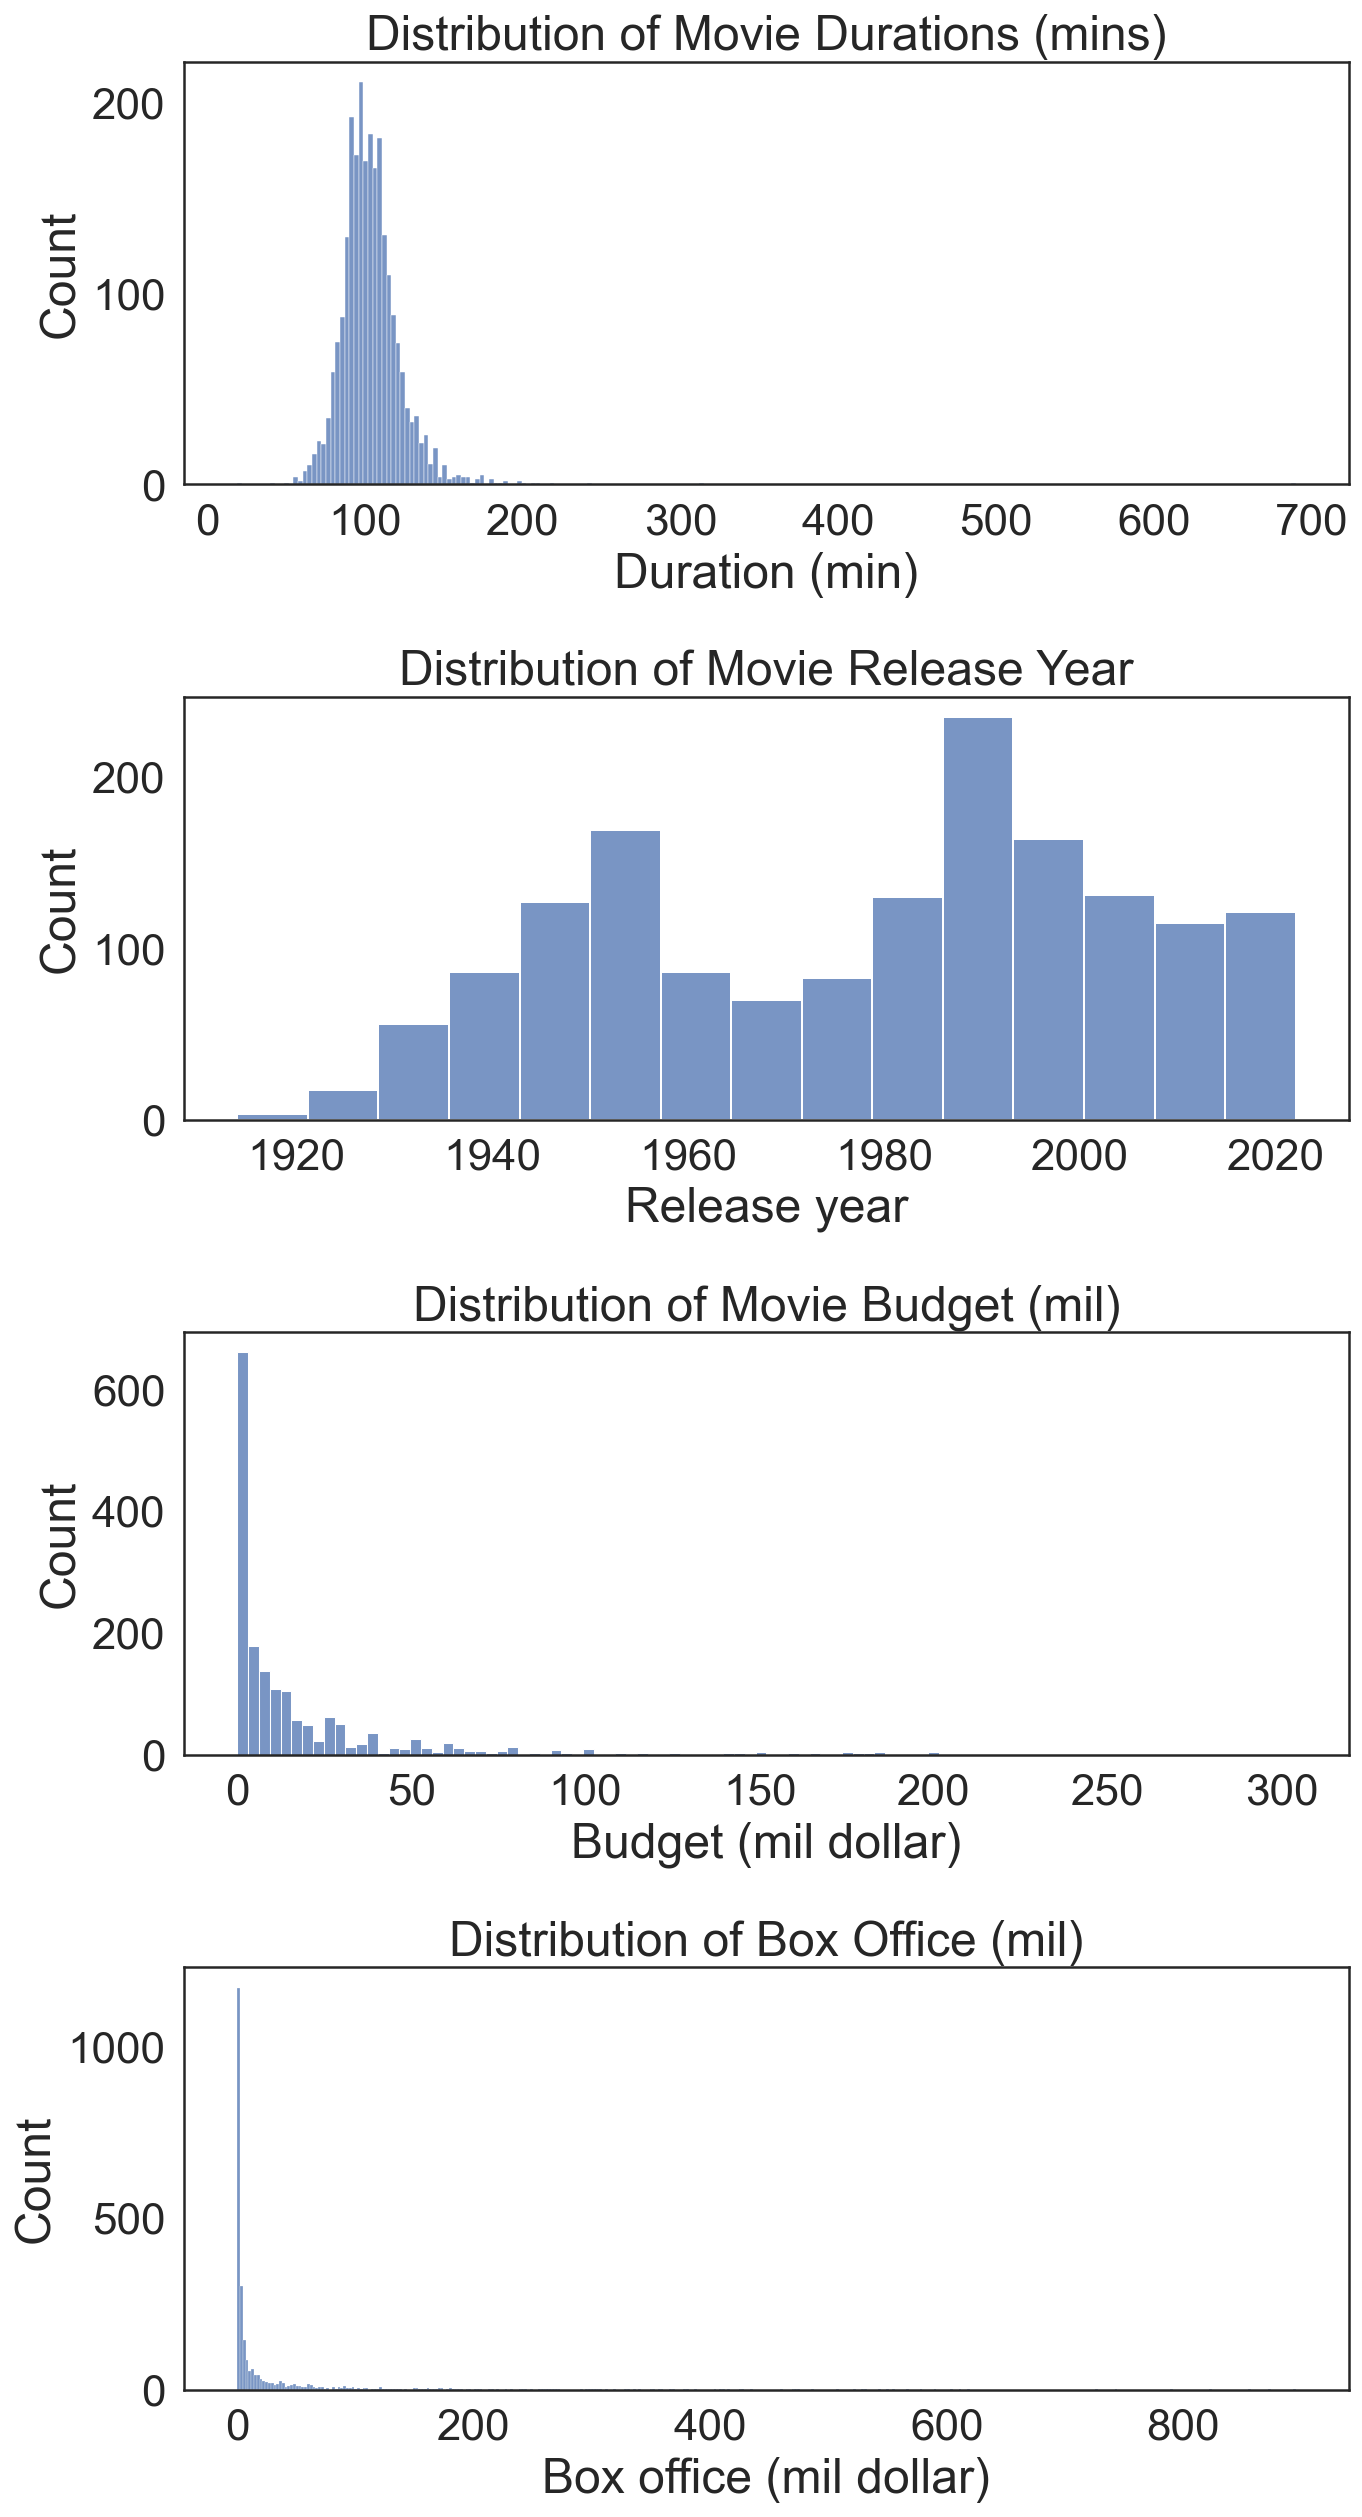

In [19]:
fig, axs = plt.subplots(4,1, figsize=(10,18))

sns.histplot(quant['Duration (min)'], ax=axs[0]).set(title='Distribution of Movie Durations (mins)')
sns.histplot(quant['Release year'], ax=axs[1]).set(title='Distribution of Movie Release Year')
sns.histplot(quant['Budget (mil dollar)'], ax=axs[2]).set(title='Distribution of Movie Budget (mil)')
sns.histplot(quant['Box office (mil dollar)'], ax=axs[3]).set(title='Distribution of Box Office (mil)')

plt.tight_layout()
plt.show()

As seen in the histograms, all columns except the release year column contain outliers. Specifically for budget and box office distributions, they both look similar and are both heavily skewed to the right.

Removing ouliers shows a clearer distribution.

[Text(0.5, 1.0, 'Distribution of Movie Budget (mil)')]

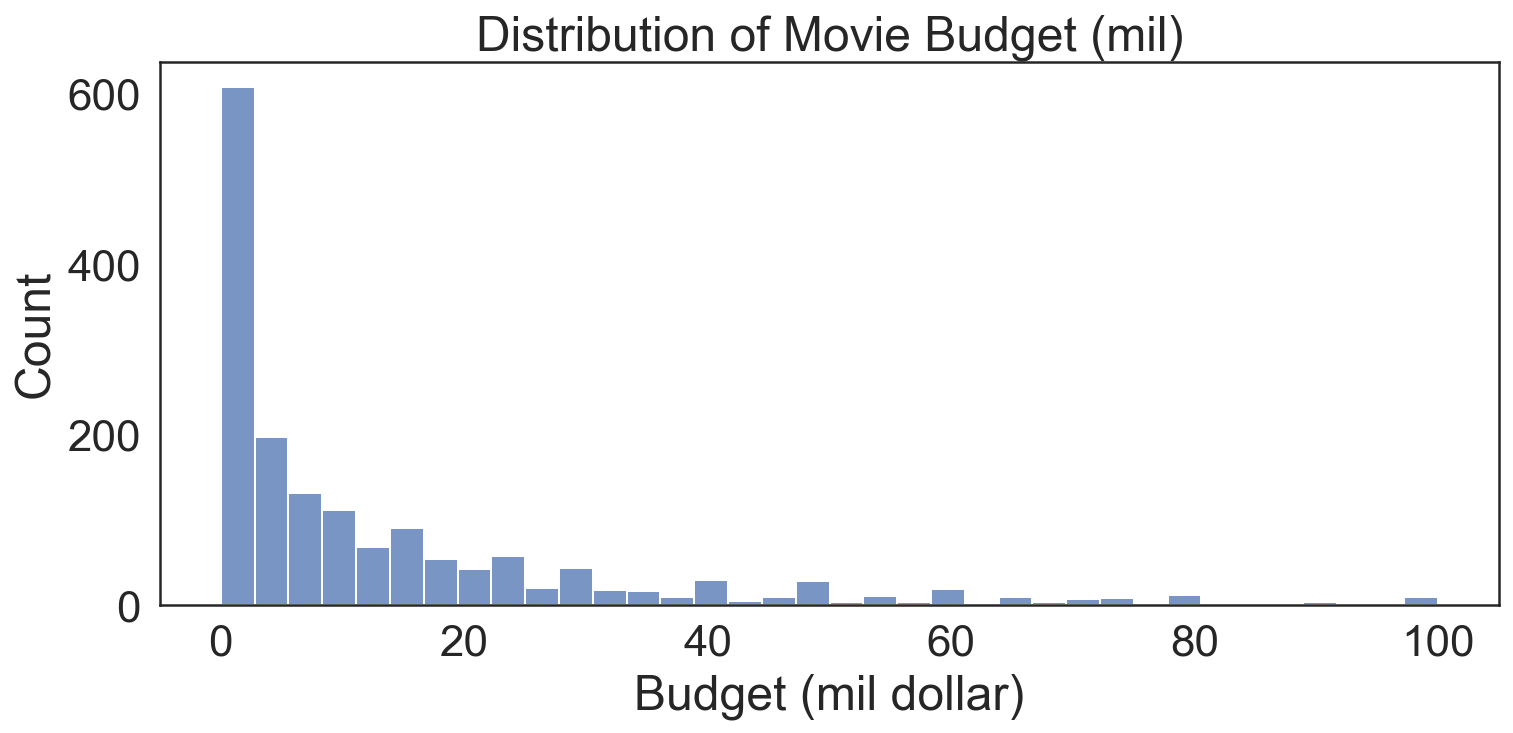

In [20]:
#Budget distribution with outliers removed
sns.histplot(quant[quant['Budget (mil dollar)'] <= 100]['Budget (mil dollar)']).set(title='Distribution of Movie Budget (mil)')


By only plotting the distribution of movies with budgets less than or equal to 100 million dollars, we can see that most movies have budgets under 20 million dollars. This also realistically makes sense given that a higher budget would neccessitate a greater box office to return a profit.

[Text(0.5, 1.0, 'Distribution of Box Office (mil)')]

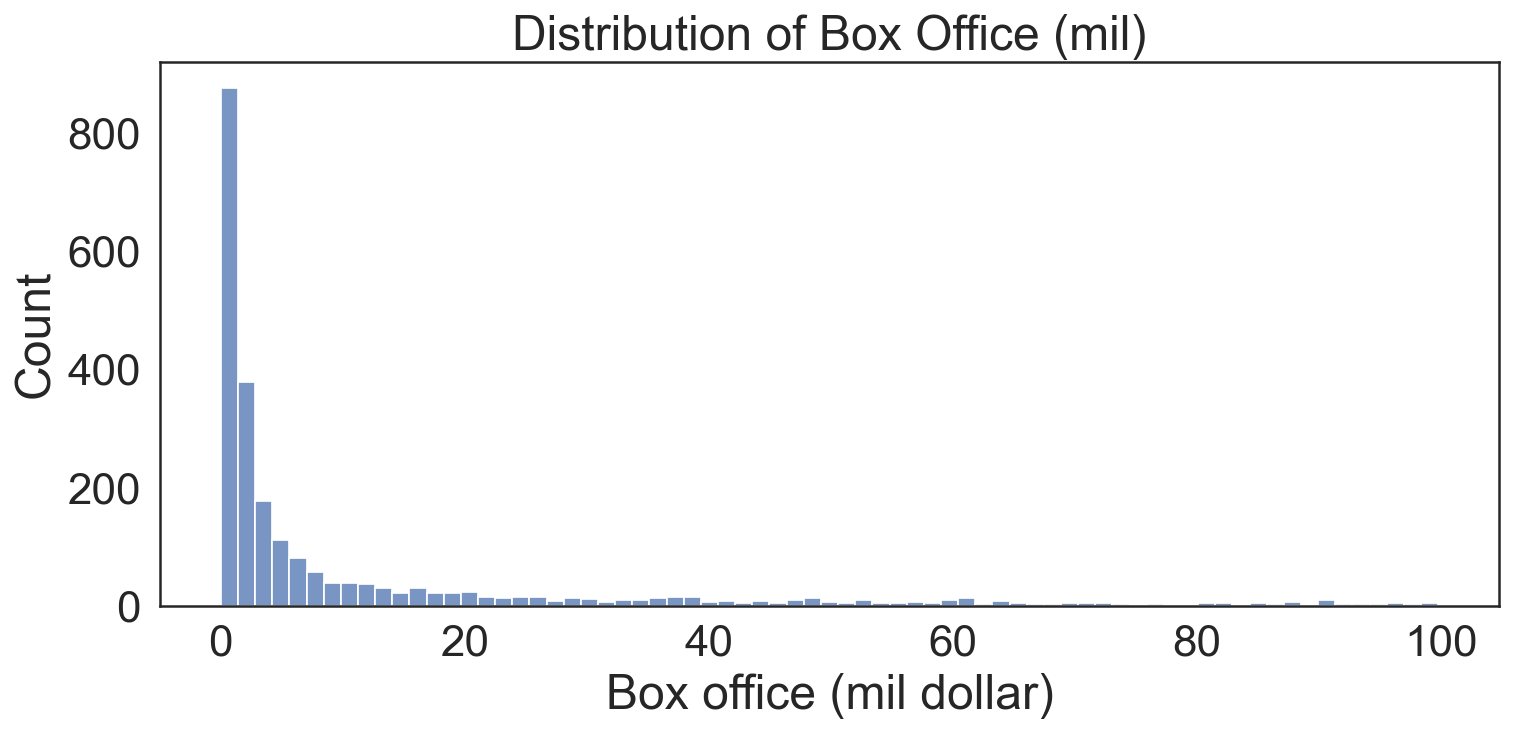

In [21]:
#Box Office distribution with outliers removed
sns.histplot(quant[quant['Box office (mil dollar)'] <= 100]['Box office (mil dollar)']).set(title='Distribution of Box Office (mil)')


Applying the same threshold to the box office data yields a distribution that looks similar to the budget distribution. This could suggest a relationship between movie budget and its respective box office amount.

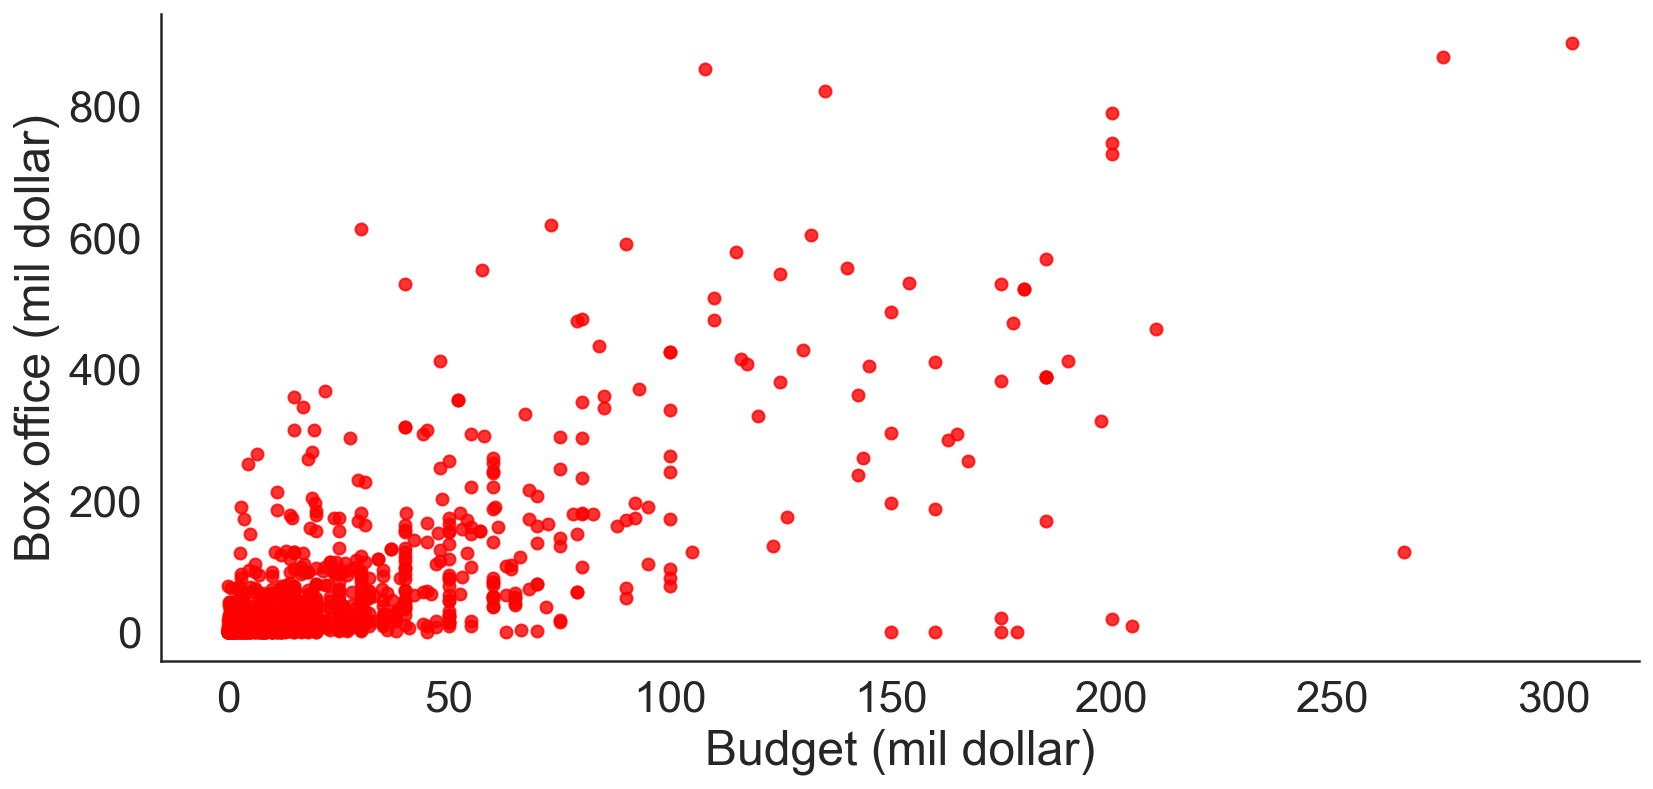

In [22]:
#Scatterplot comparing Budget and Box office (in millions)
sns.lmplot(x='Budget (mil dollar)', y='Box office (mil dollar)',data=quant, fit_reg=False, height=6,aspect=2, scatter_kws={'color':'red'})


# Analysis

Our goal is to conclude which factor has the highest correlation with American film's box office sale.

## Approach 1: Which factor has the highest correlation with "Box Office"?

In [75]:
import statsmodels.formula.api as smf 

In [76]:
variables = list(df.columns)
variables.remove('Film name')
variables.remove('Box office (mil dollar)')
variables.remove('Plot')
variables_df = pd.Series(variables).to_frame().rename(columns={0:'Variable'})

In [82]:
def get_rsquared(variable):
    reg = smf.ols(formula=f'Q("Box office (mil dollar)") ~ Q("{variable}")', data=df).fit() 
    return reg.rsquared

variables_df['R-squared'] = variables_df['Variable'].apply(get_rsquared)

In [83]:
print("According to R-squared values, the variables are ranked by correlation to box office sales (best to worst):")
variables_df.sort_values(by='R-squared', ascending=False)

,Variable,R-squared,MSE
3,Story by,0.984943,NaN
2,Written by,0.887921,NaN
1,Directed by,0.829488,NaN
4,Produced by,0.703538,NaN
7,Edited by,0.671356,NaN
5,Starring,0.664801,NaN
6,Cinematography,0.564965,NaN
12,Budget (mil dollar),0.554045,4868.740560
8,Music by,0.396010,NaN
9,Distributed by,0.304660,NaN


## Approach 2: Which factor predicts "Box Office" the best?

In [84]:
# Create training and testing dataset 
percent_train = 0.7
mask = np.random.rand(len(df)) < percent_train
train = df[mask]
test = df[~mask]

To identify which factor predicts "Box office (mil dollar)" the best, we will train an OLS model for every independent variable in our dataset.

After splitting the dataset into training and testing sets, we will fit the linear regression model OLS on the training data, then  predict "Box office (mil dollar)" using the testing data. We We will measure how good the prediction is using Mean Squared Error (MSE). The lower the MSE, the more predictive the model is.

In [85]:
from sklearn.metrics import mean_squared_error

def get_MSE_of_OLS(variable):
    X_train = train[variable].to_frame()
    y_train = train['Box office (mil dollar)'].to_frame()
    X_test = test[variable].to_frame()
    y_test = test['Box office (mil dollar)'].to_frame()

    reg = smf.ols(formula=f'Q("Box office (mil dollar)") ~ Q("{variable}")', data=train).fit() 

    try:
        y_pred = reg.predict(X_test)
        mask_to_remove_nan = np.isnan(y_pred)
        y_pred = y_pred[~mask_to_remove_nan]
        y_test = y_test[~mask_to_remove_nan]

        return mean_squared_error(y_test, y_pred)
    except:
        return np.nan

    return mean_squared_error(y_test, y_pred)

variables_df['MSE'] = variables_df['Variable'].apply(get_MSE_of_OLS)

In [86]:
print("According to MSE values, the variables are ranked by how well they predict to box office sales (best to worst):")
variables_df.sort_values(by='MSE')

,Variable,R-squared,MSE
11,Release year,0.057767,1936.994653
12,Budget (mil dollar),0.554045,4354.583374
0,Genre,0.096180,7499.343742
10,Duration (min),0.040204,8040.934466
16,VADER compound,0.010504,8222.075491
17,VADER compound (absolute value),0.014514,8272.318516
13,VADER negative,0.007240,8273.523238
14,VADER neutral,0.006358,8311.135629
19,TextBlob polarity,0.004266,8330.629059
18,TextBlob subjectivity,0.000607,8363.783117


# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*